In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
#import h5py
import sys
import os
import pyflct
from scipy.stats import pearsonr

# We need this to navigate through our data
import muram 

# Input/output
from astropy.io import fits

In [3]:
# We should import all tau_slices at Tau = 1 and see how flow tracking behaves for this data
# Initializing list of names of all the files
filenames = []

# Retreiving only numerical files
for file in sorted(os.listdir (os.getcwd())):
	if file.startswith("tau_slice"):
		#print (file)
		filenames.append(file)
#print ("How many files are in directory: {}".format(len(filenames)))

# Setting the new array length as the number of tau slices
NT = len(filenames) # timeseries

iter = 50
level = 1.0
tempfile = muram.MuramTauSlice('', iter, level)
# Let's print the shape of our file(s):
print(np.shape(tempfile))

NP, NX, NY = np.shape(tempfile) # parameters, x, y
#T_series = np.zeros([NX, NY])
T_array = []
Bz_array = []
Vx_array = []
Vy_array = []
I_continuum = []
# To make sure we are using the temperature
#plt.imshow(tempfile[8].T, origin='lower',vmin=5500,vmax=8000)

# Looping through all the slices
test_range = 3
for iter in range(test_range):
    test = filenames[iter]
    data_full = np.fromfile(test, dtype="float32")
    data = data_full[4:].reshape(11, 1536, 1536)
    T = data[8,:,:]
    Bz = data[7,:,:]
    Vx = data[1,:,:]
    Vy = data[2,:,:]
    #Int = muram.MuramIntensity('',iter)
    Vx_array.append(Vx)
    Vy_array.append(Vy)
    T_array.append(T)
    Bz_array.append(Bz)
    #I_continuum.append(Int)
	

# For easier further use we will write the data out in a fits file
# that shall be available to users

I_out_filenames = []
for file in sorted(os.listdir (os.getcwd())):
	if file.startswith("I_out"):
		#print (file)
		I_out_filenames.append(file)
#print ("How many files are in directory: {}".format(len(I_out_filenames)))

# WIP
iter = 50
I_out_filenames = ["I_out.000000", "I_out.000050", "I_out.000100"]
for iter in range(len(I_out_filenames)):
    name = I_out_filenames[iter]
    new_name = name.split(".")
    #print(new_name)
    if(int(new_name[1])%50 == 0):
        Int = muram.MuramIntensity('',int(new_name[1]))
        I_continuum.append(Int)



T_array = np.asarray(T_array)
Bz_array = np.asarray(Bz_array)
Vx_array = np.asarray(Vx_array)
Vy_array = np.asarray(Vy_array)
I_continuum = np.asarray(I_continuum)

Temp = fits.PrimaryHDU(T_array)
Bz = fits.ImageHDU(Bz_array)
Vx = fits.ImageHDU(Vx_array)
Vy = fits.ImageHDU(Vy_array)
I500 = fits.ImageHDU(I_continuum)
data_out = fits.HDUList([Temp, Bz, Vx, Vy, I500])

# Write the fits file
data_out.writeto("ISSI_2D_Tau=1.0-" + str(test_range) + "slices.fits", overwrite = True)

(11, 1536, 1536)


In [4]:
Temp = fits.open("ISSI_2D_Tau=1.0-" + str(test_range) + "slices.fits")[0].data
Bz = fits.open("ISSI_2D_Tau=1.0-" + str(test_range) + "slices.fits")[1].data
Vx = fits.open("ISSI_2D_Tau=1.0-" + str(test_range) + "slices.fits")[2].data
Vy = fits.open("ISSI_2D_Tau=1.0-" + str(test_range) + "slices.fits")[3].data
I500 = fits.open("ISSI_2D_Tau=1.0-" + str(test_range) + "slices.fits")[4].data

In [19]:
# Let's do basic comparison of "real" velocities and the ones that FLCT gives
# between every 2 adjacent files 

# Good time intervals somewhat connected to observations
 # 30s, 60s, 360s, 720s
# FWHM
 # 1200, 2400, 100, 200, 600
# 50 km = 1 pixel for Gregor

# Data shared on Globus should be in fits format 
# Full field of view should be used, while during the analysis the cropping is prefered
# Naming convention for files and FWHM + delta_t should be written in header of the file
#### sigma_pyflct is computed differently than sigma used for gaussian/normal distribution!
# The names of the variables should be discussed on may 15th

# Brian said that for sigma of 5 pixels it took 3 sec for his code to complete one frame
# and that for 18 pixels it took 3 minutes
FWHM = 2400 # km
delta_t = 30 # sec
pixelsize = 16 #
sigma_pyflct = FWHM/1.665/pixelsize
print(sigma_pyflct)

# What is the minimal part of simulation that we could show to Brian and that makes sense?
# Because time efficiency of code is heavily influenced by the value of sigma_pyflct as it stands
# and the original FLCT code that Brian wrote isn't paralelised.


# How do we compare velocities derived with those from simulation?
# 1. Pearson's coefficient as start
# 2. real life errors to be 
# 3. relative error

90.09009009009009


In [20]:
Vx_mean = []
Vy_mean = []
for j in range(1, len(Vx)):
    vx = (Vx[j-1] + Vx[j])/2/1e5
    Vx_mean.append(vx)
    vy = (Vy[j-1] + Vy[j])/2/1e5
    Vy_mean.append(vy)

In [21]:
#Now for continuum instensity array
Vel_x_I = []
Vel_y_I = []
Vm_I = []
for j in range(1, len(I500)):
    vel_x, vel_y, vm = pyflct.flct(I500[j-1], I500[j], delta_t, pixelsize, sigma_pyflct)
    Vel_x_I.append(vel_x)
    Vel_y_I.append(vel_y)
    Vm_I.append(vm)

print("Length of Vel_x_I: {}".format(len(Vel_x_I)))

flct: nominal sliding box size = 384
flct: mean value of gamma^2/sigma^2 = 0.00813176

flct: finished
flct: nominal sliding box size = 384
flct: progress Length of Vel_x_I: 2
flct: mean value of gamma^2/sigma^2 = 0.00813722

flct: finished


In [24]:
Vel_x_I = np.asarray(Vel_x_I)
Vel_y_I = np.asarray(Vel_y_I)
Vm_I = np.asarray(Vm_I)

In [25]:
# Averaged, i.e mean Vx and Vy
Vx_mean = []
Vy_mean = []
for j in range(1, len(Vx)):
    vx = (Vx[j-1] + Vx[j])/2/1e5
    Vx_mean.append(vx)
    vy = (Vy[j-1] + Vy[j])/2/1e5
    Vy_mean.append(vy)

Vx_mean = np.asarray(Vx_mean)
Vy_mean = np.asarray(Vy_mean)

In [26]:
# Pearson's correlation coefficients
px_1 = []
py_1 = []

# This is for show only
# It will be updated to run more smoothly

for j in range(1, len(Vel_x_I)):
    p_x = pearsonr(Vx_mean[j-1].flatten(), Vel_x_I[j-1].flatten())
    px_1.append(p_x)
    p_y = pearsonr(Vy_mean[j-1].flatten(), Vel_y_I[j-1].flatten())
    py_1.append(p_y)
    print("Pearson for x:{}".format(p_x))
    print("Pearson for y:{}".format(p_y))

Pearson for x:PearsonRResult(statistic=-0.00029007533655703516, pvalue=0.6559183681171812)
Pearson for y:PearsonRResult(statistic=0.055959160450340786, pvalue=0.0)


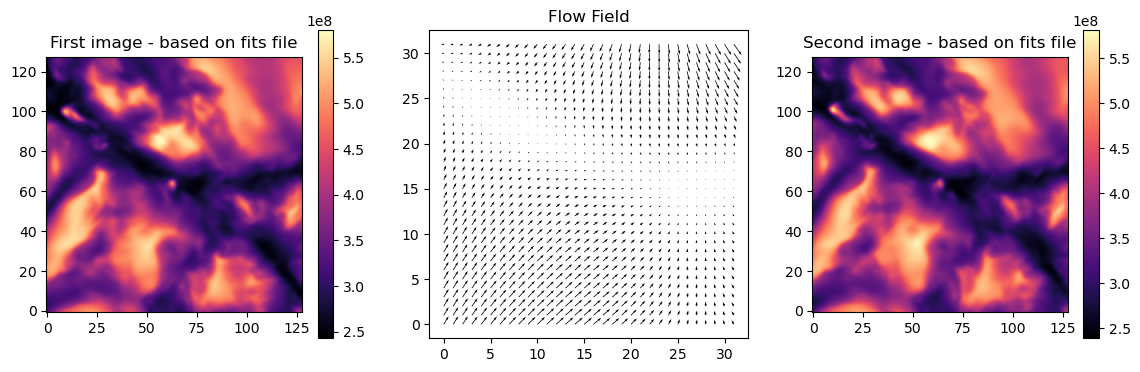

In [27]:
# Trying out intensity as windowing parameter

image1 = I500[0]
image2 = I500[1]
i_start = 0
j_start = 0
i_end = 128
j_end = 128
# But first we need to create a meshgrid on which the flow field will be plotted - prvi pokusaj
X = np.arange(0, 32, 1)
Y = np.arange(0, 32, 1)
U, V = np.meshgrid(X, Y)

# Plotting the first image
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(131)
plt.imshow(image1[i_start:i_end, j_start:j_end], origin="lower", cmap='magma')
plt.colorbar()
ax1.set_title("First image - based on fits file")

# Plot the 2D flow field
ax2 = fig.add_subplot(132)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vel_x_I[0,i_start:i_end:4, j_start:j_end:4], Vel_y_I[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field") #FLCT

# Plot the shifted image
ax3 = fig.add_subplot(133)
plt.imshow(image2[i_start:i_end, j_start:j_end], origin="lower", cmap='magma')
ax3.set_title("Second image - based on fits file")
plt.colorbar()

Text(0.5, 1.0, 'Flow Field - FLCT; continuum intensity windowing parameter')

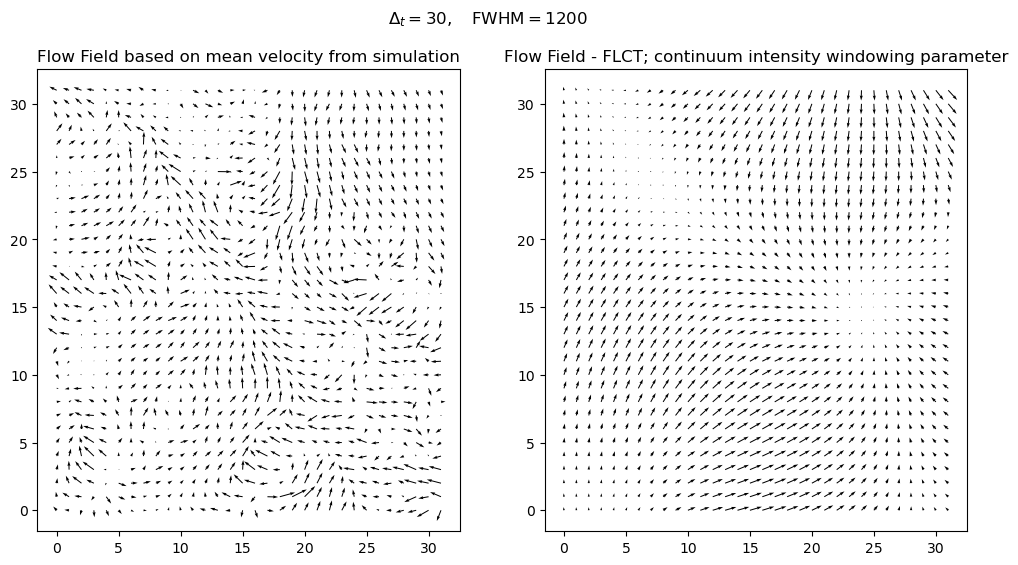

In [18]:
# Plotting the first image
fig = plt.figure(figsize=(12, 6))
fig.suptitle(r'$\Delta_t=30, \quad \mathrm{FWHM}=1200$')
ax1 = fig.add_subplot(121)
ax1.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vx_mean[0,i_start:i_end:4, j_start:j_end:4], Vy_mean[0,i_start:i_end:4, j_start:j_end:4])
ax1.set_title("Flow Field based on mean velocity from simulation") 

ax2 = fig.add_subplot(122)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          Vel_x_I[0,i_start:i_end:4, j_start:j_end:4], Vel_y_I[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field - FLCT; continuum intensity windowing parameter") 

Text(0.5, 1.0, 'Flow Field - FLCT; continuum intensity windowing parameter')

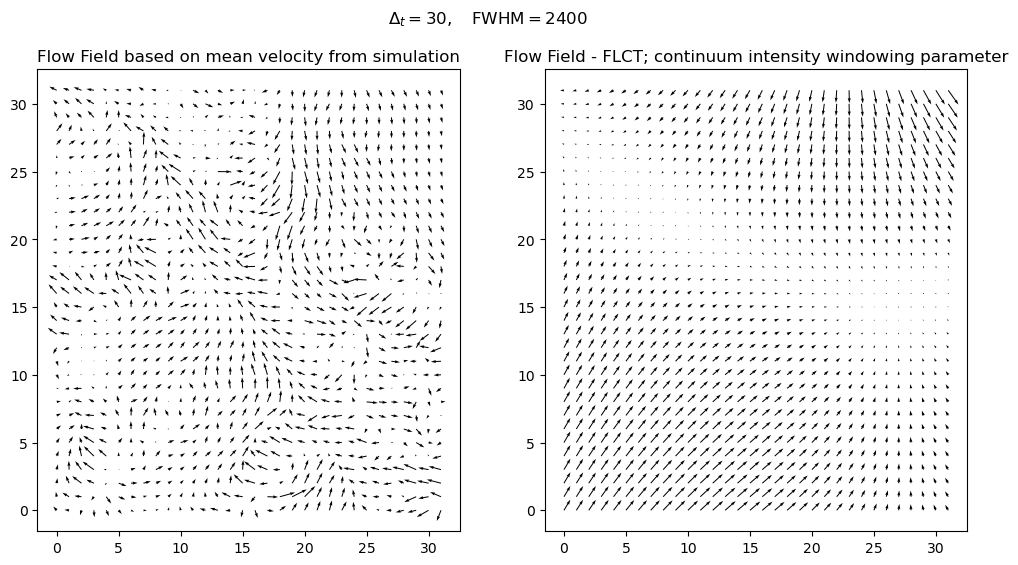

In [28]:
# Plotting the first image
fig = plt.figure(figsize=(12, 6))
fig.suptitle(r'$\Delta_t=30, \quad \mathrm{FWHM}=2400$')
ax1 = fig.add_subplot(121)
ax1.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vx_mean[0,i_start:i_end:4, j_start:j_end:4], Vy_mean[0,i_start:i_end:4, j_start:j_end:4])
ax1.set_title("Flow Field based on mean velocity from simulation") 

ax2 = fig.add_subplot(122)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          Vel_x_I[0,i_start:i_end:4, j_start:j_end:4], Vel_y_I[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field - FLCT; continuum intensity windowing parameter") 